# 중고차 가격 예측 경진대회 EDA

이번 대회는 중고차 시장 데이터를 이용하여 중고차 가격 예측을 예측하는 대회입니다.

대회를 시작하기 앞서 어떤 데이터가 주어졌고 어떤 방식으로 활용할 수 있을지 데이터를 분석하고 시각화하며 인사이트를 얻어내는 작업이 필요합니다.

# 데이터 불러오기 전처리

## 데이터 불러오기

먼저 필요한 패키지들을 설치하고 주어진 데이터를 불러오고 확인합니다.

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt   
%matplotlib inline  


# csv 형식으로 된 데이터 파일을 읽어옵니다. 
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print(f'data set은 {train.shape[1]} 개의 feature를 가진 {train.shape[0]} 개의 데이터 샘플로 이루어져 있습니다.')

# 데이터의 최상단 5 줄을 표시합니다.
train.head()

data set은 11 개의 feature를 가진 1015 개의 데이터 샘플로 이루어져 있습니다.


,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000


## 타겟 변수 

회귀 문제를 다룰때는 타겟 변수의 분포가 상당히 중요하므로 가장 먼저 살펴보겠습니다.   
이 데이터의 타겟 변수는 중고차 가격(target) 입니다.    

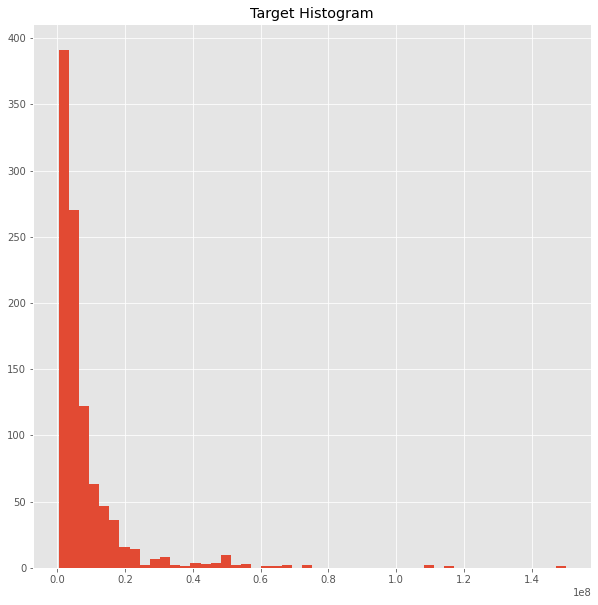

In [161]:
plt.figure(figsize=(10,10))
plt.hist(train['target'], bins=50)
plt.title('Target Histogram')
plt.show()

상당히 높은 중고차 가격들이 편차가 심하게 분포되어있는 것을 확인 할 수 있습니다.

보시다시피 굉장히 오른쪽으로 치우친 모양을 가지고 있습니다.

확실히 오른쪽 꼬리가 긴 모습인데, 가격 데이터이므로 납득이 가는 결과로 볼 수 있습니다.

이와 같은 경우 우리는 로그 변환 사용을 고려해 볼 수 있습니다.

로그변환을 사용하여 정규분포와 가깝도록 변환시켜주면 좀 더 데이터 분석에 효과적이라고 볼 수 있습니다!

그럼 target에 로그 변환을 적용해보겠습니다.

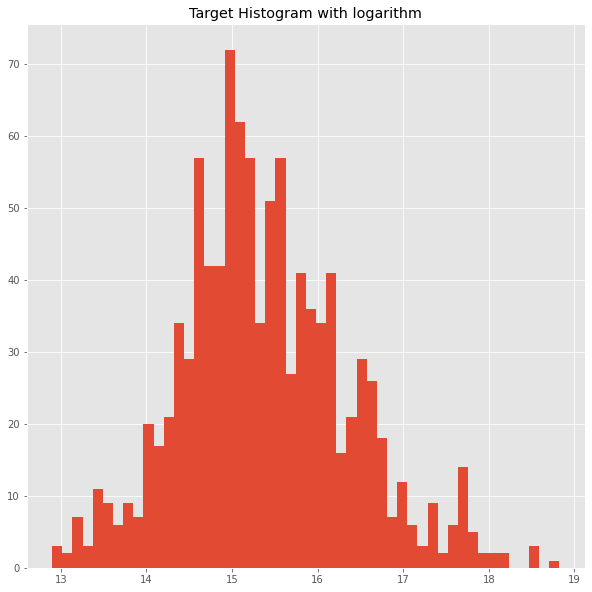

In [162]:
import numpy as np

log_target = np.log(train['target'])

plt.figure(figsize=(10,10))
plt.hist(log_target, bins=50)
plt.title('Target Histogram with logarithm')
plt.show()

타겟 변수를 로그변환한 뒤 정규성을 확인 해보았습니다. 이전보다 확실히 정규분포에 가깝네요!

## 수치형 변수

### 히스토그램

이제 수치형 변수의 분포를 보겠습니다.

수치형 변수는 odometer와 year 이 있네요.

막대그래프로 한번 분포를 살펴 볼까요?

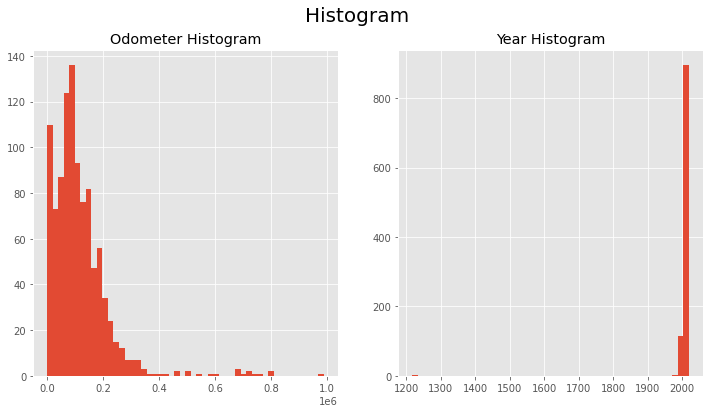

In [163]:
plt.style.use("ggplot")

plt.figure(figsize=(12,6))
plt.suptitle("Histogram", fontsize=20)

plt.subplot(1,2,1)
plt.hist(train.odometer, bins=50)
plt.title('Odometer Histogram')

plt.subplot(1,2,2)
plt.hist(train.year, bins=50)
plt.title('Year Histogram')
plt.show()

그래프를 보면, year에서 1900년도 이하인 데이터도 존재하여 데이터 분포 범위가 1200 범위부터 시작되어있는 것을 확인하였는데 잘못 기입된 데이터인지 한번 확인해볼 필요가 있습니다.

따라서 year가 1900년도 이하인 데이터가 존재하는지 확인해보도록 하겠습니다.

In [164]:
train[train['year'] < 1900]

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
415,415,Mercedes-Benz ATEGO,403461,Lagos,Locally used,4-cylinder(I4),manual,diesel,white,1218,6015000
827,827,Mercedes-Benz/52,510053,Lagos,Locally used,6-cylinder(V6),manual,diesel,white,1217,75015000


위의 year에서 1218, 1217 데이터가 존재합니다.

이는 오기입된 데이터라고 판단될 수 있으므로 제거를 해줍시다.

In [165]:
train = train[train['year'] > 1900]
train.shape

(1013, 11)

In [166]:
train = train.drop('id', axis = 1).reset_index().drop('index', axis = 1).reset_index().rename({'index':'id'}, axis = 'columns')

### 통계치

이제 수치형 데이터의 통계치를 살펴보겠습니다.

pandas의 DataFrame은 describe이라는 메소드를 통해 각 컬럼의 평균값, 최대치, 최소치, 편차 등을 알아보겠습니다.

In [167]:
data_description = train.describe().iloc[:,1:3]
data_description

,odometer,year
count,1013.000000,1013.000000
mean,116171.015795,2009.946693
std,104147.052690,5.540466
min,0.000000,1980.000000
25%,55775.000000,2006.000000
50%,94803.000000,2010.000000
75%,152878.000000,2014.000000
max,987322.000000,2020.000000


통계치를 숫자로만 봐서는 분포를 가늠하기 힘듭니다

각각 데이터 분포를 히스토그램에 평균(빨강)과 중앙값(초록)을 선으로 표시해보겠습니다.

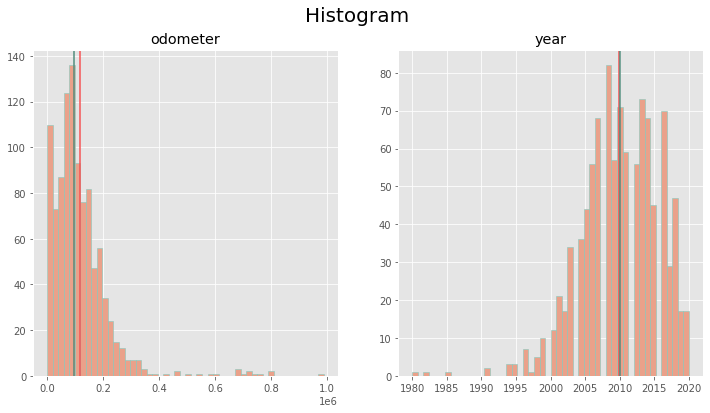

In [168]:
plt.style.use("ggplot")

plt.figure(figsize=(12,6))
plt.suptitle("Histogram", fontsize=20)

plt.subplot(1,2,1)
plt.hist(train['odometer'], bins=50, color='#eaa18a', edgecolor='#7bcabf')
plt.title('odometer')
plt.axvline(data_description['odometer']['mean'], c='#f55354', label = f"mean = {round(data_description['odometer']['mean'], 2)}")
plt.axvline(data_description['odometer']['50%'], c='#518d7d', label = f"median = {round(data_description['odometer']['50%'], 2)}")

plt.subplot(1,2,2)
# 수치형 데이터 통계치 그래프
plt.hist(train['year'], bins = 50, color='#eaa18a', edgecolor='#7bcabf')
plt.title('year')
plt.axvline(data_description['year']['mean'], c='#f55354', label = f"mean = {round(data_description['year']['mean'], 2)}")
plt.axvline(data_description['year']['50%'], c='#518d7d', label = f"median = {round(data_description['year']['50%'], 2)}")


#### Odometer 인사이트

In [169]:
print('Odometer 평균은', round(data_description['odometer']['mean']), '입니다')
print('Odometer 중앙값은', round(data_description['odometer']['50%']), '입니다')

Odometer 평균은 116171 입니다
Odometer 중앙값은 94803 입니다


평균 주행거리는 116171, 중앙값은 94803으로         
평균에 비해 중앙값이 좌측으로 치우쳐져 있습니다. 

또한 데이터 분포를 보면 좌편향 되어있는 것을 보아 주행거리가 데이터 평균에 비하여 매우 큰 값이 드물게 존재하는 것을 확인해볼 수 있습니다.

-> 따라서 주행거리 0 ~ 987,322 사이 범위에서 비교적 적은 거리의 데이터가 많이 분포한다 것을 확인하였습니다.

#### year 인사이트

In [170]:
print('Year 평균은', round(data_description['year']['mean']), '입니다')
print('Year 중앙값은', round(data_description['year']['50%']), '입니다')

Year 평균은 2010 입니다
Year 중앙값은 2010 입니다


평균 연식과 중앙값은 2010으로          
평균과 중앙값이 2010년도 인 것을 알 수 있습니다.

또한 데이터 분포를 보면 우편향 되어있는 것을 보아 연식이 데이터 평균에 비하여 매우 작은 값이 드물게 존재하는 것을 확인해볼 수 있습니다.

-> 따라서 1980~2020 범위에서 비교적 최신 연도의 데이터가 많이 분포한다는 것을 확인하였습니다.

### 타겟(가격)과 수치형 변수 상관관계 확인하기

이번엔 타겟(가격)과 수치형 변수들의 상관관계를 확인해보겠습니다.

추세선과 산점도 그래프를 그려보겠습니다.

Text(0.5, 1.0, 'year')

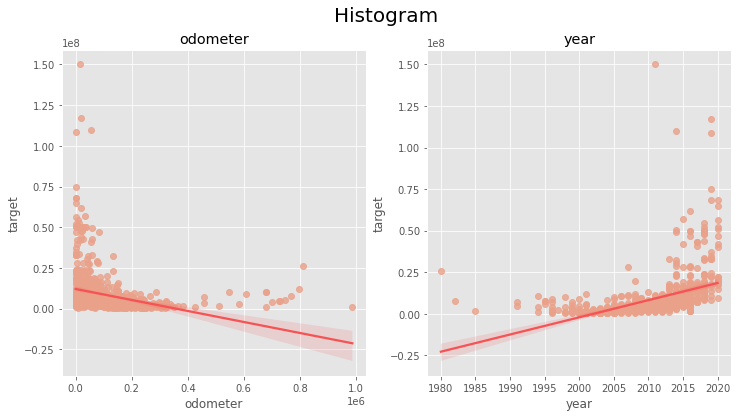

In [171]:
import seaborn as sns

plt.style.use("ggplot")

plt.figure(figsize=(12,6))
plt.suptitle("Histogram", fontsize=20)

plt.subplot(1,2,1)
sns.regplot(x='odometer', y='target', data=train,  color='#eaa18a', line_kws=  {'color': '#f55354'})
plt.title('odometer')

plt.subplot(1,2,2)
sns.regplot(x='year', y='target', data=train,  color='#eaa18a', line_kws=  {'color': '#f55354'})
plt.title('year')


#### 인사이트 

> * 그래프를 통하여 target와 odometer 관계의 추세선을 확인해 보아 왼쪽 아래 방향을 향하고 있으므로 음의 상관관계를 가지고 있음을 도출하였습니다.
> * 그래프를 통하여 target와 year 관계의 추세선을 확인해 보아 왼쪽 위 방향을 향하고 있으므로 양의 상관관계를 가지고 있음을 도출하였습니다.

### 히트맵 그려보기

앞서 추세선으로 데이터를 시각화 한 내용을 바탕으로 상관관계를 히트맵을 통하여 자세히 알아보도록 하겠습니다.

그럼 피어슨 상관관계 분석 방법을 이용하여,

feature들 간의 상관관계를 히트맵을 그려 어떤 컬럼들이 높은 상관관계를 갖는지 알아보겠습니다.


In [172]:
train

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000
...,...,...,...,...,...,...,...,...,...,...,...
1008,1008,Toyota Corolla,46768,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2014,5415000
1009,1009,Toyota Camry,31600,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,Silver,2011,3615000
1010,1010,Toyota Camry,96802,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2011,3415000
1011,1011,Lexus GX 460,146275,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Gold,2013,14315000


In [173]:
from sklearn.preprocessing import MinMaxScaler

# 수치형 데이터 상관관계 히트맵 시각화
train_corr = train[['odometer', 'year', 'target']]
scaler= MinMaxScaler() 
train_corr[train_corr.columns] = scaler.fit_transform(train_corr[train_corr.columns])
corr28 = train_corr.corr(method= 'pearson')

/tmp/ipykernel_8049/3271366270.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_corr[train_corr.columns] = scaler.fit_transform(train_corr[train_corr.columns])


Text(0.5, 1.0, 'Correlation between features')

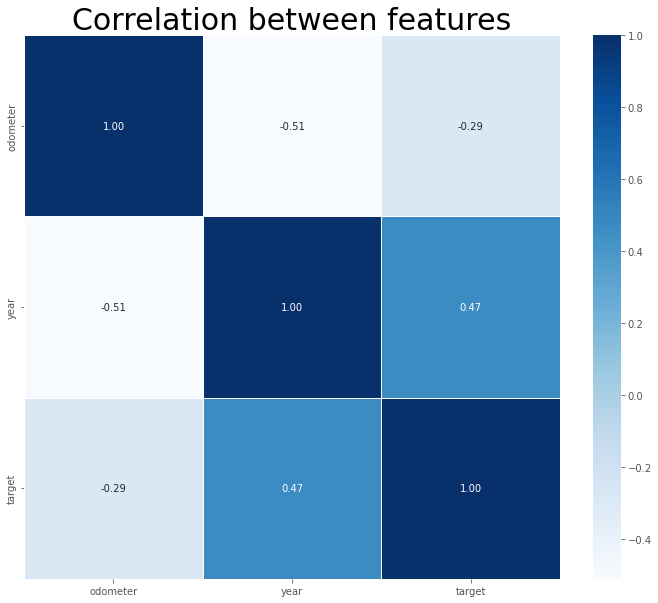

In [174]:
plt.figure(figsize=(12,10))
sns.heatmap(data = corr28, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.title('Correlation between features', fontsize=30)

In [175]:
# Target과 피쳐들의 상관관계
s28 = corr28.unstack()
df_temp28 = pd.DataFrame(s28['target'].sort_values(ascending=False), columns=['target'])
df_temp28.style.background_gradient(cmap='viridis')

,target
target,1.000000
year,0.468276
odometer,-0.287731


#### 인사이트


> * 그래프를 보니 year가 높은 양의 상관관계가 있는것으로 나타났네요! 이는 최근 연도일수록 가격이 높아진다는 것으로 해석할 수 있겠습니다.
> * 또한 odometer도 -0.29로 음의 상관관계를 띄므로 전반적으로 주행거리가 많을 수록 가격이 낮아질 것이라고 해석할 수 있겠습니다.

## 범주형 변수

이제 범주형 변수의 탐색적 자료 분석을 해보도록 하겠습니다.

### 통계치

describe에 include="object"을 주면    
범주형 변수의 count, unique, top, freq 통계치를 얻을 수 있습니다.

In [176]:
train.describe(include="object")

,title,location,isimported,engine,transmission,fuel,paint
count,1013,1013,1013,1013,1013,1013,1013
unique,201,13,3,8,2,2,76
top,Toyota Camry,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black
freq,129,790,744,617,965,970,292


unique 행을 보면 title(201)과 paint은(76)의 카테고리가 매우 많이 있는 것으로 확인이 됩니다.

이 와중에서, 가장 많은 title이 Toyota Camry 차로 129대수가 있는군요.

또한 paint은 Black 색상으로 292대수가 있습니다.

*참고로 이 메소드를 이용해서 손쉽게 범주형 변수의 컬럼 명도 뽑아 올 수 있습니다.

In [177]:
train.describe(include="object").columns

Index(['title', 'location', 'isimported', 'engine', 'transmission', 'fuel',
       'paint'],
      dtype='object')

### 파생변수 생성

그럼 이 수십개의 카테고리를 같은 카테고리로 뭉쳐 파생변수를 만들 수 있는지 좀 더 깊게 데이터 탐색을 확인해볼까요?

In [3]:
train['title'].value_counts()[:20]

Toyota Camry            129
Toyota Corolla          108
Toyota Highlander        50
Toyota Sienna            49
Toyota RAV 4             40
Honda Accord             38
Lexus RX 350             33
Lexus ES 350             24
Toyota Venza             16
Lexus GX 460             16
Honda Pilot              15
Lexus LX 570             14
Mercedes-Benz ML 350     13
Toyota Avalon            13
Mercedes-Benz GL 450     12
Toyota Matrix            12
Toyota Tacoma            12
Ford Explorer            12
Mercedes-Benz E 350      12
Toyota 4-Runner          12
Name: title, dtype: int64

도요타, 혼다, 렉서스, 벤츠 등 title 변수를 통하여 상위 변수로 Brand 변수도 생성해 낼 수 있을 것 같군요!   
브랜드 별 카테고리 변수도 추가해주면 분석에 용이할 것 같습니다.

<br>

브랜드는 띄어쓰기 기준으로 첫번째 단어에 위치해 있으므로 첫번째 단어를 플래그로 기준으로 나누어 보도록 하겠습니다.

In [179]:
train['title'].apply(lambda x : x.split(" ")[0])

0       Toyota
1       Toyota
2         Land
3        Lexus
4       Toyota
         ...  
1008    Toyota
1009    Toyota
1010    Toyota
1011     Lexus
1012       DAF
Name: title, Length: 1013, dtype: object

그럼 이 데이터를 새로운 'brand' 라는 컬럼을 생성하여 넣어주도록 할게요 !

In [180]:
train['brand'] = train['title'].apply(lambda x : x.split(" ")[0])
train.head()

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,brand
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000,Toyota
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000,Toyota
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000,Land
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000,Lexus
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000,Toyota


In [181]:
train['brand'].value_counts().head()

Toyota           474
Lexus            122
Mercedes-Benz    104
Honda             81
Ford              36
Name: brand, dtype: int64

In [182]:
print('title의 unique 카테고리 개수 : ', len(train['title'].value_counts()))
print('brand의 unique 카테고리 개수 : ', len(train['brand'].value_counts()))

title의 unique 카테고리 개수 :  201
brand의 unique 카테고리 개수 :  41


201개 카테고리에서 41개 카테고리로 줄어든 새로운 brand 파생변수를 생성했습니다.

많이 줄어들었지만 그래도 여전히 카테고리가 많긴 하군요!

### 데이터 정제

이제 paint 컬럼을 한번 살펴보도록 합시다.

In [5]:
train['paint'].value_counts()[:20]

Black        292
White        115
Silver       103
Grey          84
Blue          70
Red           53
Dark Grey     47
Gold          37
white         26
Green         18
Gray          17
Brown         16
Black         15
Dark Blue     14
Wine           8
Silver         5
Sliver         5
blue           5
red            5
Grey           3
Name: paint, dtype: int64

'Black', 'Black '

'Red', 'red' 

띄어쓰기, 대소문자가 고르지 못한 단어들이 보이는군요.

이럴 경우 정규표현식을 이용하여 통일성을 맞춰줍시다.

In [184]:
import re 

def clean_text(texts): 
    corpus = [] 
    for i in range(0, len(texts)): 
        review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"\n\]\[\>\<]', '',texts[i]) #@%*=()/+ 와 같은 문장부호 제거
        review = re.sub(r'\d+','',review)#숫자 제거
        review = review.lower() #소문자 변환
        review = re.sub(r'\s+', ' ', review) #extra space 제거
        review = re.sub(r'<[^>]+>','',review) #Html tags 제거
        review = re.sub(r'\s+', ' ', review) #spaces 제거
        review = re.sub(r"^\s+", '', review) #space from start 제거
        review = re.sub(r'\s+$', '', review) #space from the end 제거
        review = re.sub(r'_', ' ', review) #space from the end 제거
        #review = re.sub(r'l', '', review)
        corpus.append(review) 
        
    return corpus


In [185]:
temp = clean_text(train['paint']) #메소드 적용
train['paint'] = temp

In [187]:
print('brand의 unique 카테고리 개수 : ', len(train['paint'].unique()))

brand의 unique 카테고리 개수 :  51


76개에서 51개의 카테고리로 줄어들었습니다.      
그래도 여전히 많군요. 

다시한번 카테고리를 봐 봅시다.

In [189]:
train['paint'].value_counts()[:20]

black        310
white        142
silver       109
grey          87
blue          78
red           58
dark grey     48
gold          41
green         20
gray          18
dark blue     17
brown         16
wine           9
sliver         5
dark ash       4
cream          4
ash            3
purple         3
yellow         3
whiteblue      2
Name: paint, dtype: int64

'Silver, 'Sliver'         

'grey', 'dark grey'

등 오타가 있고, 

색상의 명도 및 채도 차이가 있군요.

이럴 경우에 오타를 수정해주고 대표할 수 있는 색상으로 글자를 바꿔줍시다!

In [190]:
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'blue' if x.find('blue') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'red' if x.find('red') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'green' if x.find('green') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'white' if x.find('white') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'grey' if x.find('grey') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'grey' if x.find('gery') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'grey' if x.find('gray') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'ash' if x.find('ash') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'brown' if x.find('brown') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'silver' if x.find('silver') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'silver' if x.find('sliver') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'black' if x.find('black') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'gold' if x.find('gold') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'wine' if x.find('whine') >= 0 else x)

In [191]:
train['paint'].value_counts()

black     312
grey      159
white     146
silver    117
blue      105
red        60
gold       42
green      21
brown      17
wine       10
ash         8
cream       4
purple      3
yellow      3
milk        2
maroon      2
beige       1
orange      1
Name: paint, dtype: int64

In [15]:
print('paint의 unique 카테고리 개수 : ', len(train['paint'].value_counts()))

paint의 unique 카테고리 개수 :  18


paint 변수를 76개 카테고리에서 18개 카테고리로 준 것을 확인하였습니다! 

많이 줄어든 것을 확인할 수 있습니다!

### 히스토그램

그럼 이제 데이터 분포를 확인하기 위해서

count를 나타내는 히스토그램으로 데이터의 분포를 살펴봅시다.

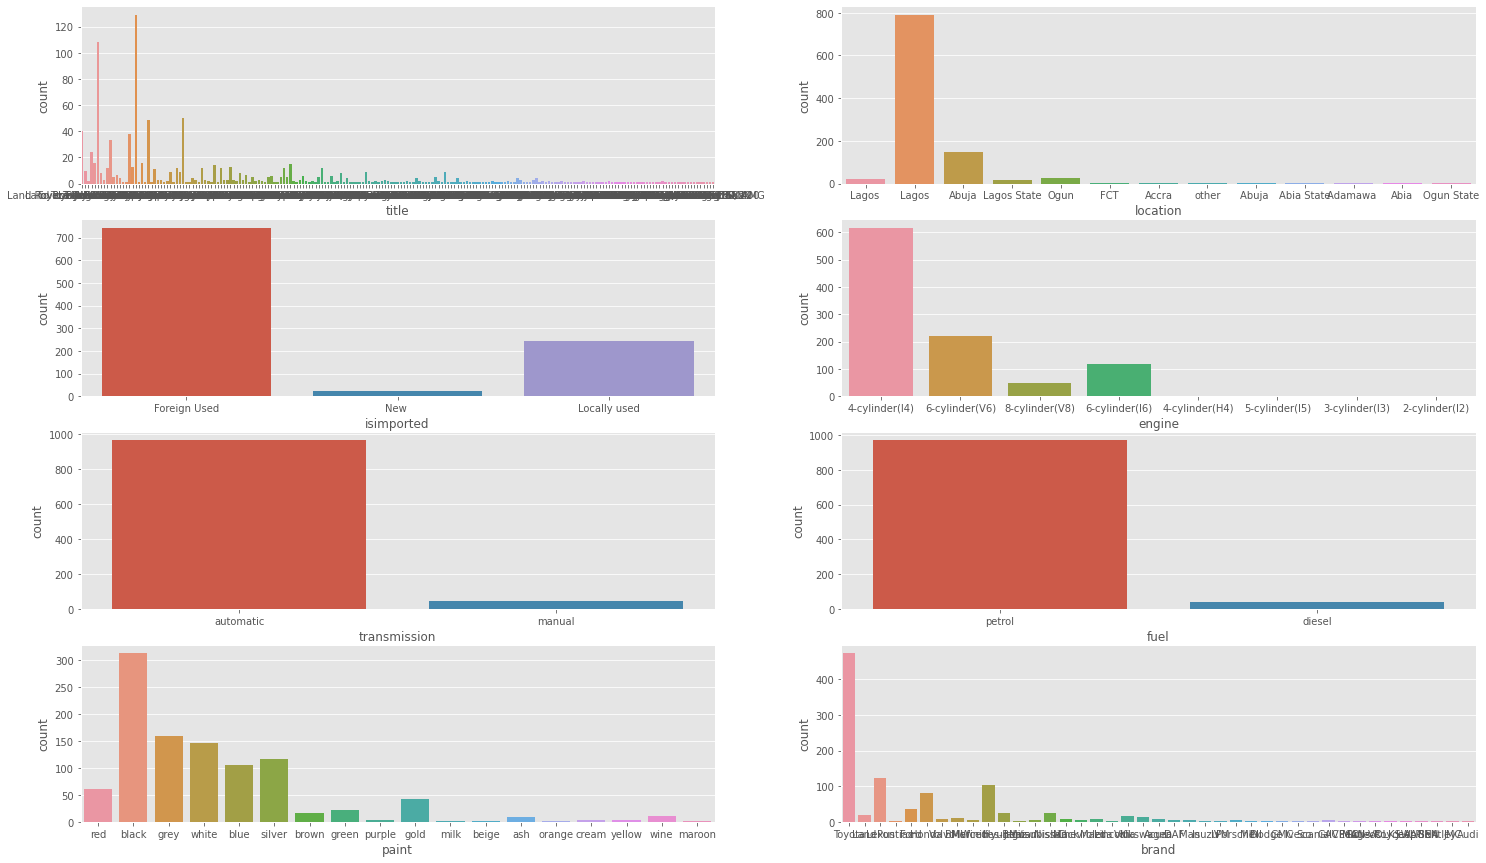

In [141]:
plt.style.use("ggplot")

plt.figure(figsize=(25,15))
count = 1

for i in train.describe(include="object").columns:
    plt.subplot(4,2,count)
    # countplot 을 사용해서 데이터의 분포를 살펴봅니다.
    sns.countplot(data=train, x=i)
    count += 1

앞서 말한 것 처럼, 여전히 title과 brand는 너무 unique 카테고리가 많아서 알아보기 힘들군요.

그럼 count 상위 15개 카테고리만 뽑아보도록 하겠습니다.

In [150]:
train_title10 = train[train['title'].apply(lambda x : x in train['title'].value_counts()[:10].keys())]
train_brand10 = train[train['brand'].apply(lambda x : x in train['brand'].value_counts()[:10].keys())]

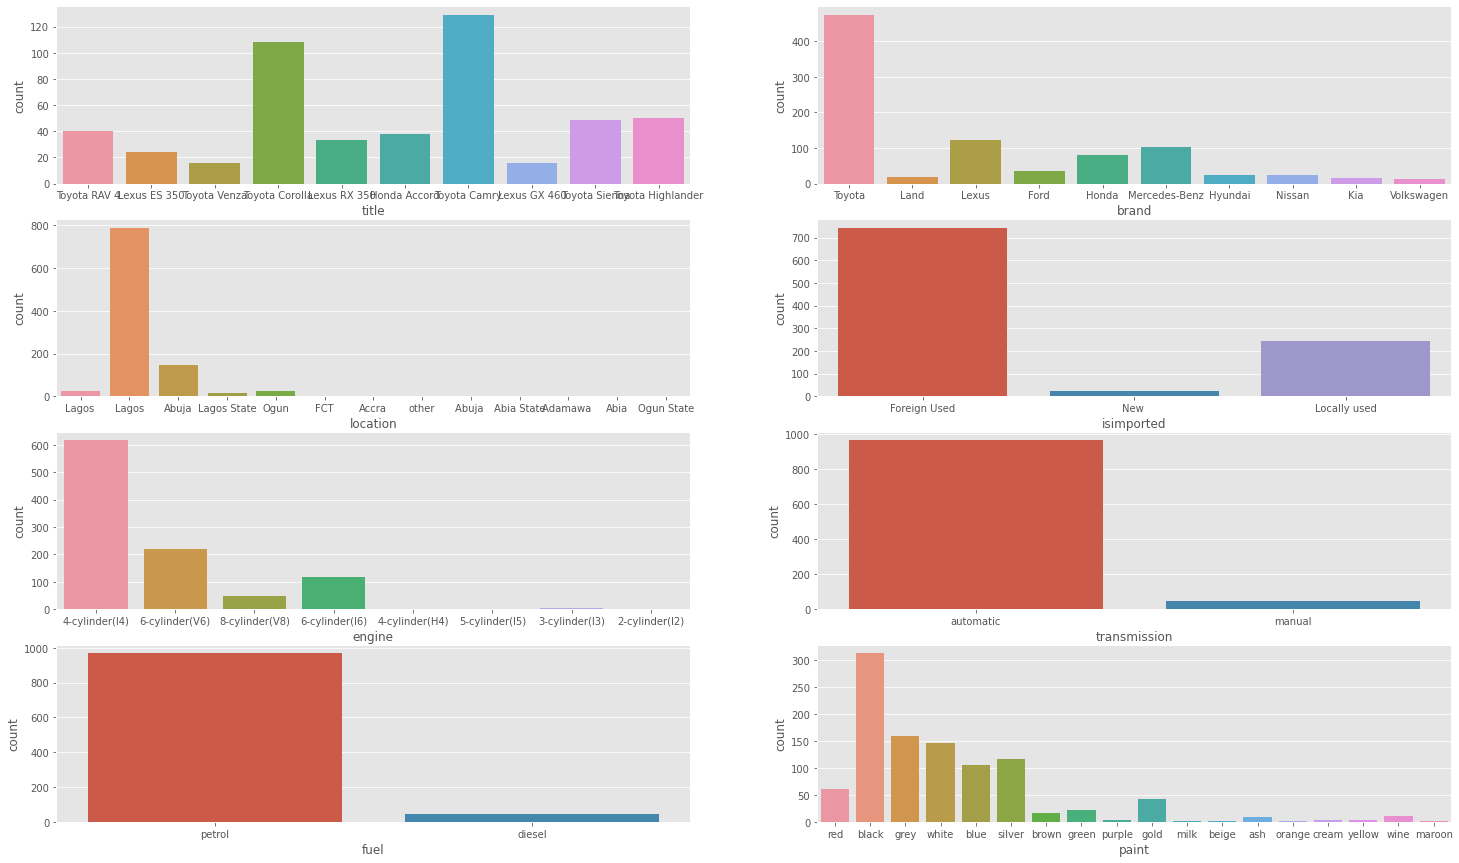

In [157]:
plt.style.use("ggplot")

plt.figure(figsize=(25,15))
plt.subplot(4,2,1)
sns.countplot(data=train_title10, x='title')
plt.subplot(4,2,2)
sns.countplot(data=train_brand10, x='brand')
count = 3

for i in train.describe(include="object").columns.drop(['title'])[:-1]:
    plt.subplot(4,2,count)
    sns.countplot(data=train, x=i)
    count += 1

#### 인사이트

단순히 count를 통하여 그래프를 간단히 해석해보도록 하겠습니다.

>* title과 brand에서 Toyota가 압도적으로 중고차가 많다는 것을 확인할 수 있습니다.
>* location에서 Lagos 지역이 압도적으로 중고차가 많다는 것을 확인할 수 있습니다.
>* isimported에서 New 차는 적고, Foreign Used>Locally used>New 순으로 중고차 대수가 이루어진 것을 확인할 수 잇습니다.
>* engine에서 4-cylinder가 압도적으로 중고차가 많다는 것을 확인할 수 있습니다.
>* trainsmission에서 automatic가 압도적으로 중고차가 많다는 것을 확인할 수 있습니다.
>* fuel에서 petrol가 압도적으로 중고차가 많다는 것을 확인할 수 있습니다.
>* paint에서 black>grey>white>sliver>red>gold .. 순으로 중고차 대수가 이루어진 것을 확인할 수 잇습니다.
-> 이를 통하여 isimported, transmission, fuel 등 몇몇 피쳐들이 데이터가 불균형이 심한 것을 확인할 수 있었습니다. 따라서 몇몇 피쳐들을 가지고 모델이 정답값인 중고차 가격을 잘 맞추기엔 '경험'이 부족할 수 있을것 같습니다.          
따라서 이 문제를 해결하기 위하여 부족한 데이터를 증강, Stratified Fold을 나누어 데이터의 분포를 같게 학습시키는 등의 방법을 이용하는 것도 좋은 접근방법이 될 것 같습니다.


### Violin plot

그럼 더 깊게 들어가 Violin plot을 통하여 카테고리별로 target과 피쳐가 어떤관계가 있는지 살펴보도록 하겠습니다.

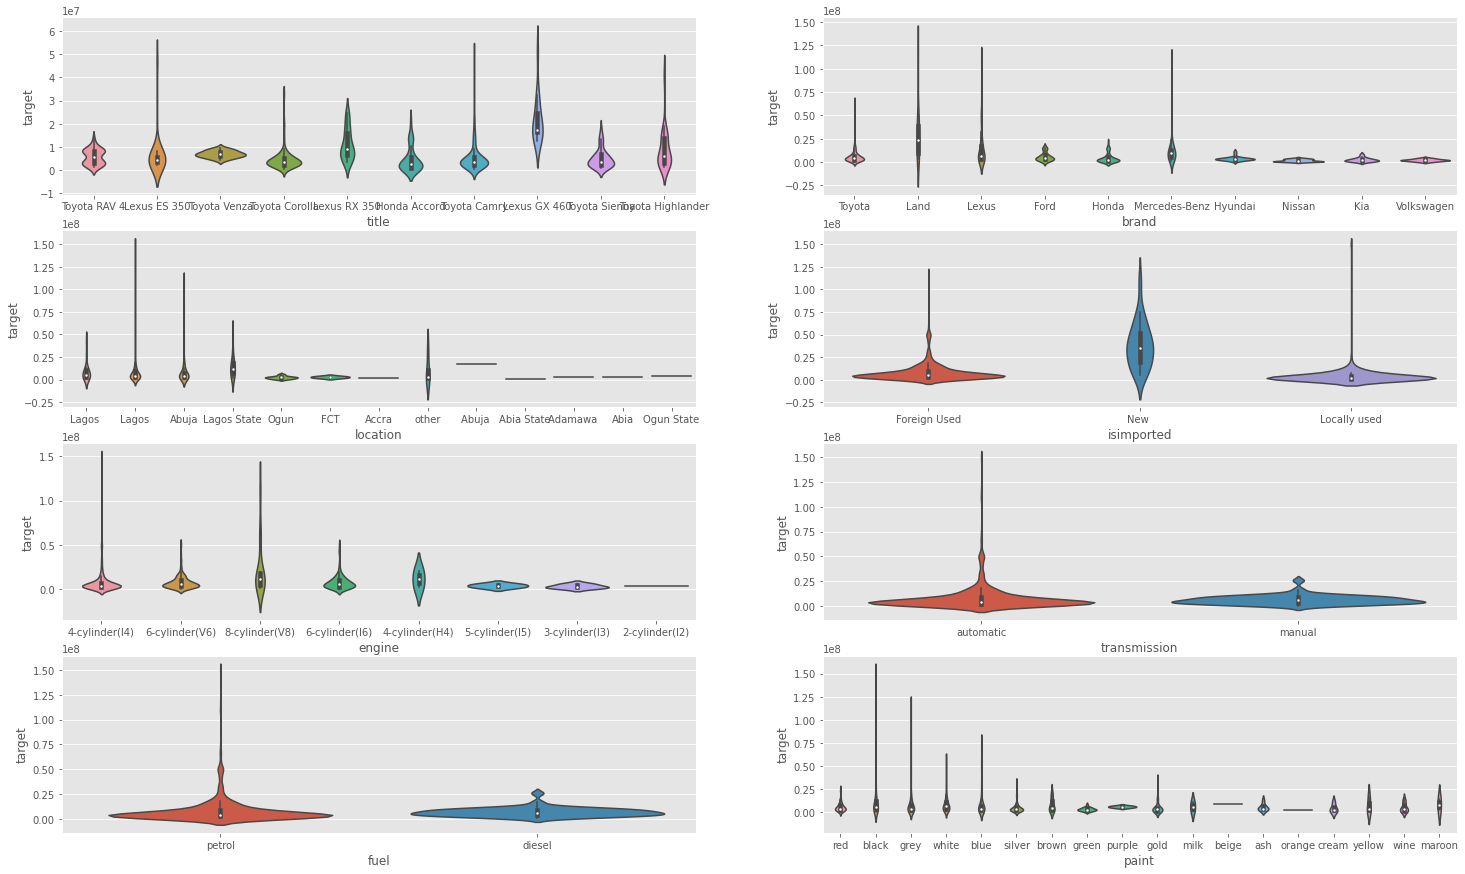

In [156]:
plt.style.use("ggplot")

plt.figure(figsize=(25,15))
plt.subplot(4,2,1)
sns.violinplot(data=train_title10, x='title', y ='target')
plt.subplot(4,2,2)
sns.violinplot(data=train_brand10, x='brand', y ='target')
count = 3

for i in train.describe(include="object").columns.drop(['title'])[:-1]:
    plt.subplot(4,2,count)
    sns.violinplot(data=train, x=i, y ='target')
    count += 1

#### 인사이트

Vilolin plot을 통하여 인사이트 도출을 해보겠습니다.

>* title과 brand에서 Land, Lexus Benz가 높은 가격대를 형성하고 있다는 것을 확인할 수 있습니다.
>* location에서 Lagos, Abuja가 높은 가격대를 형성하고 있다는 것을 확인할 수 있습니다.
>* isimported에서 New가 높은 가격대를 형성하고 있다는 것을 확인할 수 있습니다.
>* engine에서 4-cylinde와 8-cylinder가 높은 가격대를 형성하고 있다는 것을 확인할 수 있습니다.
>* trainsmission에서 automatic가 높은 가격대를 형성하고 있다는 것을 확인할 수 있습니다.
>* fuel에서 petrol가 높은 가격대를 형성하고 있다는 것을 확인할 수 있습니다.
>* paint에서 black>grey>bule가 높은 가격대를 형성하고 있다는 것을 확인할 수 있습니다.
-> 데이터 불균형이 심한 new, automatic, petrol은 아무래도 데이터가 많은쪽이 분포가 넓다고 해석할 수 있으니 조금 더 조심히 살펴보아야 할 속성인 것 같습니다.     
그리고 engine, transmission, fuel, paint에서 Vilolin plot 분포의 확률 밀도가 가장 큰 곳의 높낮이가 비슷한 것을 보아 대체적으로 카테고리들의 분포의 최빈값은 피쳐별로 비슷하게 형성되어있는 것 같습니다.


## 마치며

여러분은 어떤 인사이트를 얻으셨나요?

이번 EDA를 통해 어떤 방식으로 분석을 진행해야겠다는 자그마한 인사이트를 얻으셨으면 좋겠습니다.

여러분도 여러분만의 EDA를 진행하시고 코드공유에 올려주세요!

좋아요와 댓글을 합산하여 가장 높은 점수를 얻으신 분께 데이콘 후드가 제공됩니다!